## Imports / Data Preparation

In [146]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import tarfile
import random
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [147]:
tf.device('/GPU:0')

Download CIFAR-10 dataset.

In [148]:
data = "./cifar-10-batches-py"

### Preprocessing

In [149]:
def load_cifar10_batch(batch_filename):
    with open(batch_filename, 'rb') as f:
        dict = pickle.load(f, encoding='bytes')
        X = dict[b'data']
        Y = dict[b'labels']
        X = X.reshape(-1, 3, 32, 32).astype("float32")
        X = np.transpose(X, (0, 2, 3, 1))  # Convert to NHWC
        Y = np.array(Y)
        return X, Y

def load_cifar10(data_dir):
    X_train = []
    Y_train = []
    # There are 5 training batches
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        X, Y = load_cifar10_batch(batch_file)
        X_train.append(X)
        Y_train.append(Y)
    X_train = np.concatenate(X_train)
    Y_train = np.concatenate(Y_train)
    # Load test batch
    X_test, Y_test = load_cifar10_batch(os.path.join(data_dir, 'test_batch'))
    return X_train, Y_train, X_test, Y_test

# Specify the path to the extracted CIFAR-10 data
data_dir = data  # Change this path if different

# Load the data
X_train, Y_train, X_test, Y_test = load_cifar10(data_dir)

print(f"Training data shape: {X_train.shape}, Training labels shape: {Y_train.shape}")
print(f"Test data shape: {X_test.shape}, Test labels shape: {Y_test.shape}")

Training data shape: (50000, 32, 32, 3), Training labels shape: (50000,)
Test data shape: (10000, 32, 32, 3), Test labels shape: (10000,)


In [150]:
# Prepare the dataset
def preprocess_data(X, Y):
    X = X / 255.0  # Normalize to [0,1]
    X = X.astype(np.float32)
    Y = Y.astype(np.int32)
    return X, Y

X_train_p, Y_train_p = preprocess_data(X_train, Y_train)
X_test_p, Y_test_p = preprocess_data(X_test, Y_test)


### Important constants/hyperparameters

Some constants/information about the dataset:

In [151]:
# Hyperparameters
batch_size = 128
learning_rate = 1e-4

In [152]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_p, Y_train_p))
train_dataset = train_dataset.shuffle(buffer_size=50000).batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test_p, Y_test_p))
test_dataset = test_dataset.batch(batch_size)

In [153]:
image_shape = X_train.shape[1:] # Shape of CIFAR-10 images
image_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                 'dog', 'frog', 'horse', 'ship', 'truck']
n_class = len(image_labels)  # Number of classes

### Data Visualization

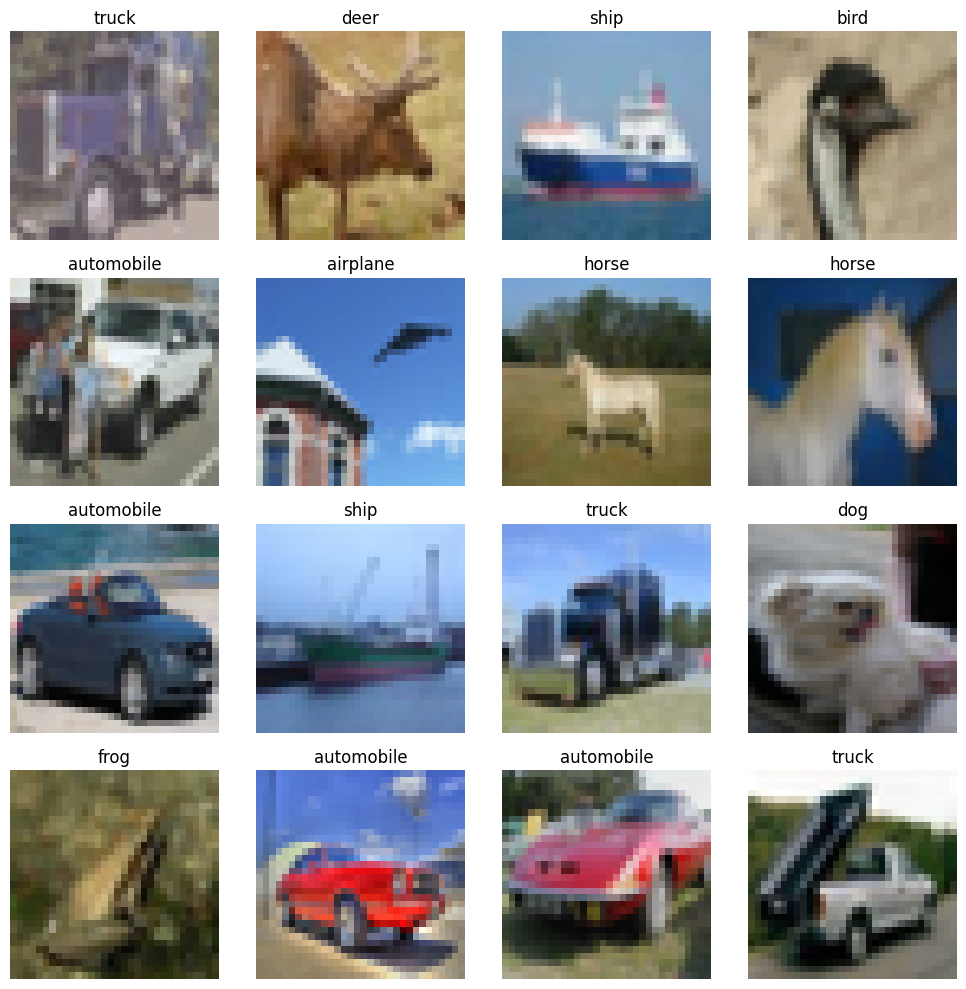

In [154]:
# [Q1]
def visualize_samples(X, Y, num_samples=16):
    # Calculate grid dimensions
    grid_size = int(np.sqrt(num_samples))
    
    # Create a figure with a grid of subplots
    plt.figure(figsize=(10, 10))
    
    # Randomly select samples
    indices = np.random.choice(len(X), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.imshow(X[idx])
        plt.title(image_labels[Y[idx]])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 16 training samples
visualize_samples(X_train_p, Y_train_p)

## Classification Task

### Model

In [155]:
# [C1]
class ResBlock(tf.keras.Model):
    def __init__(self, in_channels : int, out_channels : int, downsampling = False):
        super(ResBlock, self).__init__()
        
        # First convolutional layer
        self.conv1 = layers.Conv2D(out_channels, kernel_size=3, strides=2 if downsampling else 1, padding='same')
        self.bn1 = layers.BatchNormalization()
        
        # Second convolutional layer
        self.conv2 = layers.Conv2D(out_channels, kernel_size=3, strides=1, padding='same')
        self.bn2 = layers.BatchNormalization()
        
        # Shortcut connection
        self.need_shortcut = downsampling or in_channels != out_channels
        if self.need_shortcut:
            self.shortcut = tf.keras.Sequential([
                layers.Conv2D(out_channels, kernel_size=1, strides=2 if downsampling else 1, padding='same'),
                layers.BatchNormalization()
            ])
        
        # ReLU activation
        self.relu = layers.ReLU()

    def call(self, x):
        # Main path
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        # Shortcut path
        if self.need_shortcut:
            shortcut = self.shortcut(x)
            out = layers.Add()([out, shortcut])
        else:
            out = layers.Add()([out, x])
        
        # Final ReLU
        out = self.relu(out)
        
        return out

In [156]:
# [C2]
class WRN(tf.keras.Model):
    def __init__(self, num_classes : int = 10):
        super(WRN, self).__init__()
        
        # Initial convolution
        self.conv1 = layers.Conv2D(16, kernel_size=3, strides=1, padding='same')
        self.bn1 = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
        # First block group (16 channels)
        self.block1_1 = ResBlock(16, 16)
        self.block1_2 = ResBlock(16, 16)
        
        # Second block group (32 channels)
        self.block2_1 = ResBlock(16, 32, downsampling=True)
        self.block2_2 = ResBlock(32, 32)
        
        # Third block group (64 channels)
        self.block3_1 = ResBlock(32, 64, downsampling=True)
        self.block3_2 = ResBlock(64, 64)
        
        # Global average pooling
        self.avg_pool = layers.GlobalAveragePooling2D()
        
        # Dense layer for classification
        self.dense = layers.Dense(num_classes)
        
        # Store number of classes
        self.num_classes = num_classes

    def call(self, x):
        # Initial convolution
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        # Block groups
        out = self.block1_1(out)
        out = self.block1_2(out)
        
        out = self.block2_1(out)
        out = self.block2_2(out)
        
        out = self.block3_1(out)
        out = self.block3_2(out)
        
        # Classification head
        out = self.avg_pool(out)
        out = self.dense(out)
        
        return out

### Part 1 Training

In [157]:
# [C3]
def part1_train_step(optim : optimizers.Optimizer, model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor, sigma : float = 0.03) -> dict:
    # preprocessing
    x = data + tf.random.normal(data.shape) * sigma
    y = tf.one_hot(label, model.num_classes)

    # train model
    with tf.GradientTape() as g:
        # calculate loss here
        logits = model(x)
        loss = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y, logits))

    # obtain the gradients and apply them (using optimizer)
    grad = g.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    # return loss (or other values if needed)
    return {
        "loss": loss.numpy()
    }

# =======================

In [158]:
def train_loop_1(model, optimizer, train_step, epochs : int = 20, save_interval : int = 5):
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_dataset, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
                # Execute a train step and get the losses
                loss_dict = train_step(optimizer, model, batch_x, batch_y)
                epoch_loss += loss_dict["loss"]

                # Accumulate number of batches (for average loss calculation)
                num_batches += 1

                # Update the progress bar description with the current loss
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        # # Uncomment to test accuracy during training (Implement that first!)
        test_accuracy = evaluate_accuracy(model, test_dataset)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        # Feel free to modify this to save your progress somewhere else
        if epoch % save_interval == 0:
            model.save_weights(f'model-{epoch}.weights.h5')


### Evaluation

In [159]:
# [C4]
def evaluate_accuracy(model, dataset):
    correct = 0
    total = 0
    # Wrap the dataset with tqdm to create a progress bar
    with tqdm(dataset, unit="batch") as tepoch:
        tepoch.set_description(f"Evaluating")
        for batch_x, batch_y in tepoch:
            batch_size = tf.shape(batch_x)[0]

            # Compute logits and get predictions
            logits = model(batch_x)
            preds = tf.argmax(logits, axis=1)

            # Cast batch_y to int64 to match preds data type and compute accuracy
            batch_y = tf.cast(batch_y, tf.int64)
            correct += tf.reduce_sum(tf.cast(tf.equal(preds, batch_y), tf.int32))
            total += batch_size

            # Update the progress bar with current accuracy
            accuracy = correct / total
            tepoch.set_postfix(accuracy=f"{accuracy:.4f}")

    return accuracy



Evaluating: 100%|██████████| 79/79 [00:09<00:00,  8.09batch/s, accuracy=0.0901]


Test Accuracy: 9.01%


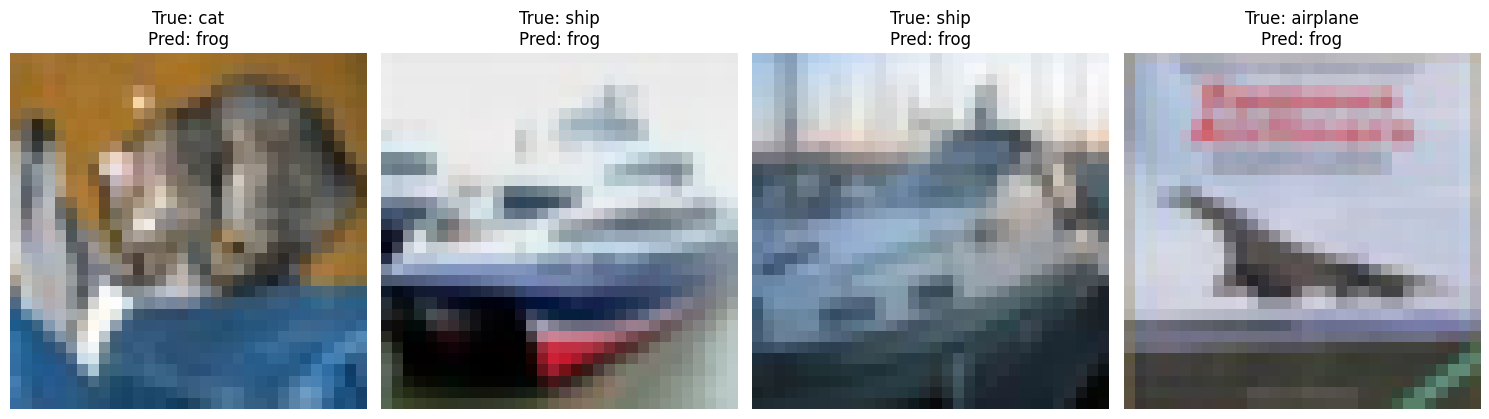

In [160]:
# [Q5] Report the accuracy of the test dataset and show at least 4 misclassified samples

model = WRN(num_classes=n_class)

# First, evaluate the model on test dataset
test_accuracy = evaluate_accuracy(model, test_dataset)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Function to find and visualize misclassified samples
def visualize_misclassified(model, dataset, num_samples=4):
    misclassified_images = []
    misclassified_labels = []
    misclassified_preds = []
    
    for batch_x, batch_y in dataset:
        # Get predictions
        logits = model(batch_x)
        preds = tf.argmax(logits, axis=1)
        
        # Find misclassified samples - ensure both tensors are int64
        batch_y = tf.cast(batch_y, tf.int64)
        preds = tf.cast(preds, tf.int64)
        mask = tf.not_equal(preds, batch_y)
        
        if tf.reduce_any(mask):
            # Get misclassified samples from this batch
            misclassified_indices = tf.where(mask)[:, 0]
            for idx in misclassified_indices:
                if len(misclassified_images) >= num_samples:
                    break
                misclassified_images.append(batch_x[idx])
                misclassified_labels.append(batch_y[idx])
                misclassified_preds.append(preds[idx])
        
        if len(misclassified_images) >= num_samples:
            break
    
    # Visualize misclassified samples
    plt.figure(figsize=(15, 5))
    for i in range(len(misclassified_images)):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(misclassified_images[i])
        true_label = image_labels[misclassified_labels[i]]
        pred_label = image_labels[misclassified_preds[i]]
        plt.title(f'True: {true_label}\nPred: {pred_label}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize misclassified samples
visualize_misclassified(model, test_dataset)

### Execute training

In [161]:
# Instantiate the model
model = WRN(num_classes=n_class)

# Define the optimizer
optimizer = optimizers.Adam(learning_rate=learning_rate)

In [162]:
train_loop_1(model, optimizer, part1_train_step, 20)

Evaluating: 100%|██████████| 79/79 [00:10<00:00,  7.90batch/s, accuracy=0.1034]


Test Accuracy: 10.34%
Epoch 1, Average Loss: 8.7610


Epoch 2:  45%|████▌     | 176/391 [01:29<01:49,  1.96batch/s, loss=8.06]


KeyboardInterrupt: 

### Regularization

In [ ]:
# [C5] Implement your regularization method here

class ResBlockRE(tf.keras.Model):
    def __init__(self, in_channels : int, out_channels : int, downsampling = False):
        super(ResBlockRE, self).__init__()


        # implement code here
        # implement the methods by modifying this class



        # =======================


    def call(self, x):
        # implement code here



        # =======================

class WRNRE(tf.keras.Model):
    def __init__(self, num_classes : int = 10):
        super(WRNRE, self).__init__()

        # implement code here



        # =======================

    def call(self, x):
        # implement code here



        # =======================


In [ ]:
# Instantiate the model
model_re = WRNRE(num_classes=n_class)

# Define the optimizer
optimizer_re = optimizers.Adam(learning_rate=learning_rate)


In [ ]:
train_loop_1(model_re, optimizer_re, part1_train_step, 20)


In [ ]:
# [Q6] Report the accuracy of the test dataset after implementing regularization methods

## Part 2: Generation Task

### Energy Function

In [ ]:
# [C6]
def energy(model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor | None = None):
  # implement code here

  # =======================


In [ ]:
def visualize_energy(model: tf.keras.Model, sample_index: int = 20):
    # Sample an image from the test dataset
    # implement code here

    # =======================
    images = [real_image, noise_image, grey_image]
    exy = []
    ex = []
    names = ['Real', 'Noise', 'Grey']
    fig, axes = plt.subplots(1, 3, figsize=(10, 3))
    for i, ax in enumerate(names):
        exy.append(energy(model, tf.expand_dims(images[i], 0), real_label).numpy()[0])
        ex.append(energy(model, tf.expand_dims(images[i], 0)).numpy()[0])
        axes[i].imshow(images[i])
        axes[i].set_title(f"{ax} E(x,y): {exy[i]:.2f}, E(x) {ex[i]:.2f}")
        axes[i].axis('off')
    plt.show()

In [ ]:
# [Q7]
visualize_energy(model, 20)

### Sampling x

In [ ]:
# [C7]
def sampling_step(model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor | None = None, step_size : float = 1, noise_amp : float = 0.01):
    # This forces the gradienttape to only track gradients for the input data:
    with tf.GradientTape(watch_accessed_variables = False) as g:
        g.watch(data)
        # calculate energy here (aggregate with sum)
        # implement code here

        # =======================


    # implement code here

    # calculate the gradient


    # update data with gradient + gaussian noise

    # =======================


    # ensure that the sample is in the valid pixel space
    data = tf.clip_by_value(data, 0, 1)

    return data

### Replay Buffer

In [ ]:
# [C8]
class SampleBuffer:
    """ A buffer storing some past trained (negative) samples. """
    def __init__(self, sample_shape, n_class : int, max_samples : int = 10000, dtype : np.dtype = np.float32):
        self.max_samples = max_samples
        self.sample_shape = sample_shape
        self.n_class = n_class
        self.dtype = dtype
        self.buffer = []

    def add_to_buffer(self, samples, ids):
        """ Add samples to replay buffer (self.buffer). If there are too many samples in the buffer, remove the oldest ones (first in, first out). """
        # implement code here


        # =======================

    def sample_from_buffer(self, n_samples : int, p_new : float = 0.05):
        """ Sample batch of n_sample samples, with each sample being either new (with probability p_new) or from buffer."""
        if len(self.buffer) == 0:
            # Initial case
            n_new = n_samples
        else:
            n_new = np.random.binomial(n_samples, p_new)

        if n_new > 0:
            # Sample uniform random data
            # implement code here

            # =======================
        else:
            noise, noise_class = [], []

        if n_new < n_samples:
            # Sample from existing data
            # implement code here

            # =======================
        else:
            replay, replay_class = [], []

        sample = tf.stack(list(noise) + list(replay), axis = 0)
        sample_class = tf.stack(list(noise_class) + list(replay_class), axis = 0)

        return sample, sample_class

In [ ]:
def visualize_buffer_samples(buffer : SampleBuffer, num_samples : int = 16, p_new : float = 0.05):
    # Retrieve samples and their corresponding labels from the buffer
    samples, labels = buffer.sample_from_buffer(num_samples, p_new)
    # Visualize the samples
    plt.figure(figsize=(10, 10))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(samples[i].numpy())  # Convert to uint8 for proper image display
        plt.xlabel(image_labels[labels[i].numpy()])
    plt.show()

sample_shape = X_train_p[0].shape
buffer = SampleBuffer(sample_shape, n_class)
# Add some initial data to the buffer
buffer.add_to_buffer(X_train_p[:100], Y_train_p[:100])  # Add first 100 samples as an example

In [ ]:
#[Q8]
visualize_buffer_samples(buffer, num_samples=16, p_new=0.5)

### JEM Training

In [ ]:
#[C9]
def part2_train_step(optim : optimizers.Optimizer, model : tf.keras.Model, data : tf.Tensor, label : tf.Tensor, sb : SampleBuffer, sigma : float = 0.03) -> dict:
    batch_size = len(data)
    # preprocessing
    x, y = (data + tf.random.normal(data.shape) * sigma), tf.one_hot(label, model.num_classes)

    # implement code here

    # sample images and labels (x', y') from SampleBuffer

    # run sampling step on x' 20 times, then add the final result back to the buffer

    # =======================


    # train model
    with tf.GradientTape() as g:
        # implement code here

        # calculate loss here, by:
        # 1. obtainig model output for x and x'

        # 2. calculate cross-entropy and energy values

        # 3. aggregate and calculate the final loss using the mentioned values

        # =======================
    # obtain the gradients and apply them (using optimizer)
    centry = tf.reduce_mean(centry)
    grad = g.gradient(loss, model.trainable_variables)
    optim.apply_gradients(zip(grad, model.trainable_variables))

    # return loss (or other values if needed)
    return {
        "loss": loss.numpy(),
        "class_loss": centry.numpy()
    }

In [ ]:
def train_loop_2(model, optimizer, train_step, epochs : int = 5, save_interval : int = 1, buffer : SampleBuffer | None = None) -> SampleBuffer:
    if buffer is None:
        buffer = SampleBuffer(X_train[0].shape, n_class)
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        num_batches = 0

        # Wrap the training dataset with tqdm to create a progress bar
        with tqdm(train_dataset, unit="batch") as tepoch:
            for step, (batch_x, batch_y) in enumerate(tepoch):
                # Execute a train step and get the losses
                loss_dict = train_step(optimizer, model, batch_x, batch_y, buffer)
                epoch_loss += loss_dict["loss"]

                # Accumulate number of batches (for average loss calculation)
                num_batches += 1

                # Update the progress bar description with the current loss
                tepoch.set_description(f"Epoch {epoch}")
                tepoch.set_postfix(**loss_dict)

        # Uncomment to test accuracy during training (Implement that first!)
        test_accuracy = evaluate_accuracy(model, test_dataset)
        print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

        avg_loss = epoch_loss / num_batches
        print(f"Epoch {epoch}, Average Loss: {avg_loss:.4f}")

        # Feel free to modify this to save your progress somewhere else
        if epoch % save_interval == 0:
            model.save_weights(f'model-{epoch}.weights.h5')

    return buffer

### Execute training

In [ ]:
# Instantiate the model
model_2 = WRN(num_classes=n_class)

# Define the optimizer
optimizer_2 = optimizers.Adam(learning_rate=learning_rate)

If the training diverges, please restart the training

In [ ]:
buf = train_loop_2(model_2, optimizer_2, part2_train_step, 2)